<a href="https://colab.research.google.com/github/yonghwadragon/GAN_DDIM_Cat_Generation/blob/main/GAN_cat_20240701_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flickr API를 사용하여 고양이 사진 다운로드

In [ ]:
!pip install flickrapi
!pip install pillow
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
from flickrapi import FlickrAPI
from urllib.request import urlretrieve
import os, time, traceback
from google.colab import userdata

# Flickr API 키 설정
key = "cee8e2db7cb3b5062d02870f0cf2e562"
secret = userdata.get('secret_flickrapi')

wait_time = 1

# 사진 저장 디렉토리 설정
savedir = "cat"
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Flickr API를 통해 고양이 사진 검색 및 다운로드
flickr = FlickrAPI(key, secret, format="parsed-json")
res = flickr.photos.search(text="cat", per_page=50, media="photos", sort="relevance", safe_search=1, extras="url_q, license")

photos = res['photos']['photo']

try:
    for i, photo in enumerate(photos):
        url_q = photo['url_q']
        filepath = os.path.join(savedir, photo['id'] + '.jpg')
        if os.path.exists(filepath): continue
        print(str(i + 1) + ": download =", url_q)
        urlretrieve(url_q, filepath)
        time.sleep(wait_time)
except:
    traceback.print_exc()


1: download = https://live.staticflickr.com/5598/14934282524_344c84246b_q.jpg
2: download = https://live.staticflickr.com/5213/5508784414_d2d84f9c92_q.jpg
3: download = https://live.staticflickr.com/8750/16386660144_a6c4026657_q.jpg
4: download = https://live.staticflickr.com/7073/7190755946_ea97e85765_q.jpg
5: download = https://live.staticflickr.com/3914/15171599148_6ef1d09dab_q.jpg
6: download = https://live.staticflickr.com/3940/15504684310_f555c88915_q.jpg
7: download = https://live.staticflickr.com/1729/41676479745_ae6d27ee9d_q.jpg
8: download = https://live.staticflickr.com/1701/24811748270_3102fc52fb_q.jpg
9: download = https://live.staticflickr.com/4733/27257168879_464200ea90_q.jpg
10: download = https://live.staticflickr.com/6100/6303228181_59371c29dc_q.jpg
11: download = https://live.staticflickr.com/280/31389231292_e2444d0260_q.jpg
12: download = https://live.staticflickr.com/5444/31233883846_0f44793ced_q.jpg
13: download = https://live.staticflickr.com/5757/30033063091_770

고양이 이미지를 NumPy 배열로 로드하고 전처리

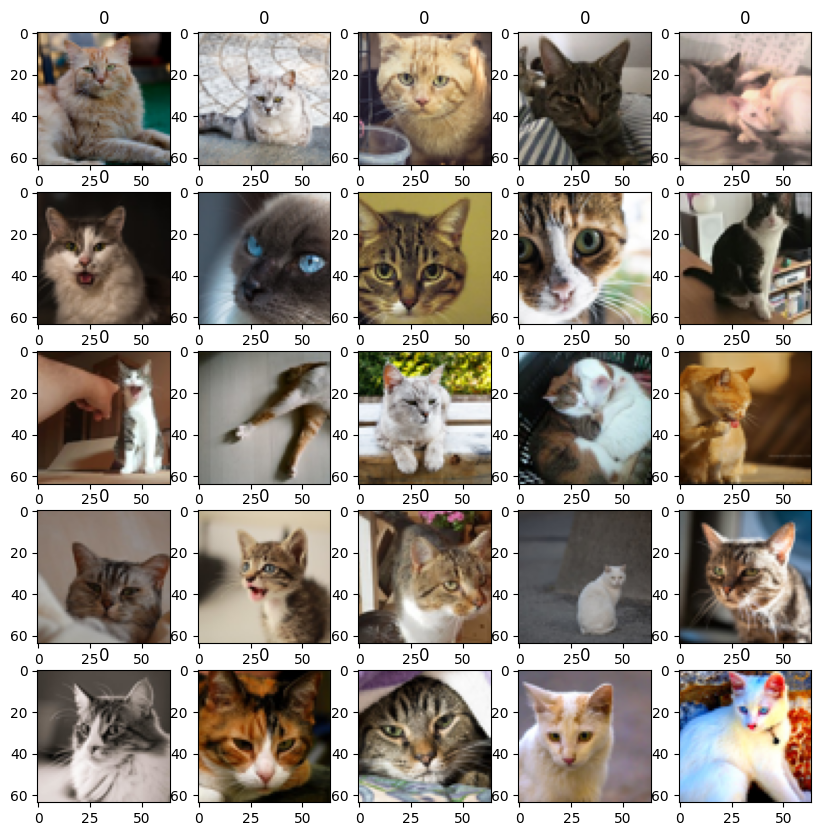

In [ ]:
import numpy as np
from PIL import Image
import glob, random
import matplotlib.pyplot as plt

# 이미지 전처리 및 NumPy 배열로 로드
max_photo = 1000
photo_size = 64
x = []
y = []

files = glob.glob(os.path.join(savedir, "*.jpg"))
random.shuffle(files)

num = 0

for f in files:
    if num >= max_photo: break
    num += 1
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((photo_size, photo_size))
    img = np.asarray(img)
    x.append(img)
    y.append(0)  # Label을 0으로 지정

x = np.array(x)
y = np.array(y)

# 이미지 출력
idx = 0
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.title(y[i + idx])
    plt.imshow(x[i + idx])
plt.show()

GAN 모델 구성

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 생성자 모델 정의
def build_generator():
    model = Sequential()
    model.add(Dense(256*8*8, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

# 판별자 모델 정의
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN 모델 정의
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# 모델 생성
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

모델 훈련

In [ ]:
def train_gan(gan, generator, discriminator, epochs, batch_size, save_interval):
    # Normalize the images to [-1, 1]
    x_train = (x - 127.5) / 127.5

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs = x_train[idx]

        # Fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_imgs(generator, epoch)

def save_imgs(generator, epoch, image_grid_rows=4, image_grid_columns=4):
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

모델 훈련 시작

1/1 [==============================] - 1s 616ms/step
0 [D loss: 0.6810336112976074, acc.: 40.625] [G loss: 0.5306078195571899]
1/1 [==============================] - 0s 214ms/step


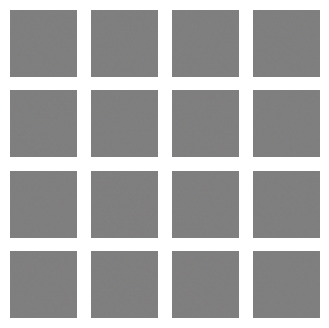

1/1 [==============================] - 0s 176ms/step
200 [D loss: 4.79287673194051e-06, acc.: 100.0] [G loss: 4.726923634734703e-07]
1/1 [==============================] - 0s 106ms/step


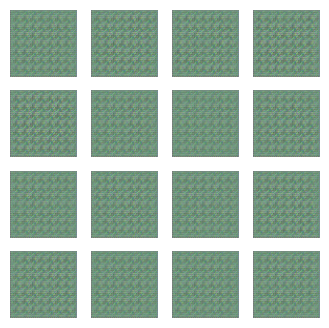

1/1 [==============================] - 0s 179ms/step
400 [D loss: 1.4648163528363511e-05, acc.: 100.0] [G loss: 4.602217131832731e-07]
1/1 [==============================] - 0s 104ms/step


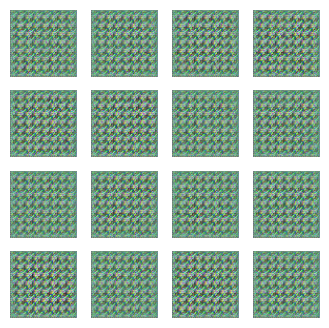

1/1 [==============================] - 0s 279ms/step
600 [D loss: 0.5636846423149109, acc.: 71.875] [G loss: 0.9108296632766724]
1/1 [==============================] - 0s 105ms/step


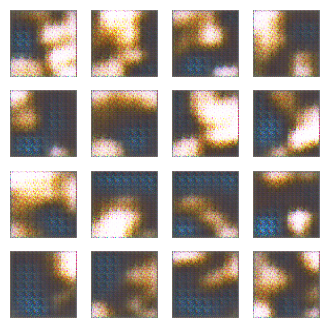

1/1 [==============================] - 0s 181ms/step
800 [D loss: 0.5056082308292389, acc.: 78.125] [G loss: 0.7583123445510864]
1/1 [==============================] - 0s 116ms/step


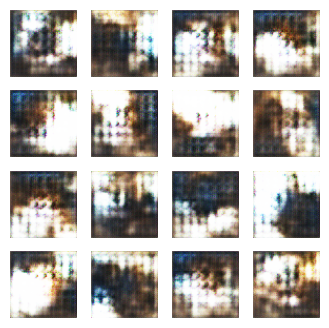

1/1 [==============================] - 0s 191ms/step


KeyboardInterrupt: 

In [ ]:
train_gan(gan, generator, discriminator, epochs=10000, batch_size=64, save_interval=200)